<a href="https://colab.research.google.com/github/TheCaveOfAdullam/2026-reserch-1/blob/main/mobileNet_test_plus2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torch_pruning
!pip install ptflops
!pip install fvcore

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F # 추가됨.
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, confusion_matrix
import torch.nn.utils.prune as prune
import torch_pruning as tp
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm
from ptflops import get_model_complexity_info
import time
import random

In [ ]:
seed = 48
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # GPU 사용 시
np.random.seed(seed)
random.seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 48 91.35

In [ ]:
categories = ['normal', 'fault_BB', 'fault_RI', 'fault_SM', 'fault_BELT']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== 저장된 데이터 로딩용 Dataset =====
class PreprocessedDataset(Dataset):
    def __init__(self, pt_file):
        data = torch.load(pt_file, weights_only=False)
        self.X = data['X']
        self.y = data['y']

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx].T
        y = self.y[idx]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# ===== CSV 읽기 없이 바로 로딩 =====
train_dataset = PreprocessedDataset('/content/drive/MyDrive/11kw pro data/train_processed.pt')
val_dataset   = PreprocessedDataset('/content/drive/MyDrive/11kw pro data/val_processed.pt')
test_dataset  = PreprocessedDataset('/content/drive/MyDrive/11kw pro data/test_processed.pt')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)

print("빠른 데이터 로딩 완료!")

빠른 데이터 로딩 완료!


In [ ]:
# --------------------------------------------------------
# MobV2 Block (Depthwise + Pointwise)
# --------------------------------------------------------
class MobV2Block1D(nn.Module):
    def __init__(self, cin, cout, expand_ratio=2, dropout=0.2):
        super().__init__()
        hidden_dim = cin * expand_ratio

        self.block = nn.Sequential(
            nn.Conv1d(cin, hidden_dim, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU6(inplace=True),

            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, stride=2, padding=1,
                      groups=hidden_dim, bias=False),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU6(inplace=True),

            nn.Conv1d(hidden_dim, cout, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(cout)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.block(x)
        return self.dropout(x)


# --------------------------------------------------------
# CNN1D_MobV2_Paper + Dropout + FC 앞 Dropout 추가
# --------------------------------------------------------
class CNN1D_MobV2_Paper_Dropout(nn.Module):
    def __init__(self, num_classes=5, dropout=0.2):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=15, stride=1, padding=7, bias=False),
            nn.BatchNorm1d(16),
            nn.ReLU6(inplace=True),
        )
        self.dropout = nn.Dropout(dropout)

        # 4개의 MobileNetV2 B-block
        self.block1 = MobV2Block1D(16, 32, dropout=dropout)
        self.block2 = MobV2Block1D(32, 64, dropout=dropout)
        self.block3 = MobV2Block1D(64, 128, dropout=dropout)
        self.block4 = MobV2Block1D(128, 256, dropout=dropout)

        # Global pooling
        self.pool = nn.AdaptiveMaxPool1d(4)

        # FC 앞 dropout 추가
        self.pre_fc_dropout = nn.Dropout(dropout)

        # FC layer
        self.fc = nn.Linear(256 * 4, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.dropout(x)   # Stem Dropout

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        x = self.pool(x)
        x = x.reshape(x.size(0), -1)

        x = self.pre_fc_dropout(x)   # FC 직전 Dropout 추가

        x = self.fc(x)
        return x

# --------------------------------------------------------
# 테스트
# --------------------------------------------------------
if __name__ == "__main__":
    model =  CNN1D_MobV2_Paper_Dropout(num_classes=5)
    x = torch.randn(8, 1, 1024)  # batch=8, 1채널, 길이 1024
    out = model(x)
    print("Output:", out.shape)

    # 파라미터 수 계산
    total_params = sum(p.numel() for p in model.parameters())
    print("Total params:", total_params)
    print("Model size (MB):", total_params * 4 / (1024**2))

Output: torch.Size([8, 5])
Total params: 140277
Model size (MB): 0.5351142883300781


In [ ]:
# 모델 학습 함수 (학습 곡선 기록 추가)
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, max_norm=1.0):
    model.to(device)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        train_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

        for inputs, labels in train_loader_iter:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            train_loader_iter.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # 학습 곡선 시각화
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

    return model

In [ ]:
# 모델 평가 함수
def evaluate_model(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 샘플 수 기반의 loss 계산
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # 전체 샘플 수로 나눔 → 샘플 평균 Loss
    average_val_loss = val_loss / total
    val_accuracy = 100 * correct / total

    return average_val_loss, val_accuracy

In [ ]:
def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    model_size = (param_size + buffer_size) / 1024**2  # Convert to MB

    if model_size < 1.0:
        return model_size * 1024, "KB"   # KB로 변환하여 반환
    else:
        return model_size, "MB"          # MB 단위 그대로 반환

In [ ]:
# F1 스코어 계산
def calculate_f1_score(model, loader, device):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    print(f"F1 Score: {f1:.4f}")

In [ ]:
# 비제로 가중치 계산 함수
def count_nonzero_weights(model):
    nonzero_count = 0
    total_count = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            nonzero_count += torch.sum(param != 0).item()
            total_count += param.numel()
    return nonzero_count, total_count

In [ ]:
# 모델 초기화 및 학습 설정
# Determine input_length from the dataset
# Assuming the first element of train_dataset returns a tensor of shape (sequence_length,)
first_input_sample, _ = train_dataset[0]
input_length = first_input_sample.shape[1]

model =  CNN1D_MobV2_Paper_Dropout(num_classes=len(categories), dropout=0.2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4) # weight_decay 값을 조정하여 L2 정규화 강도 설정

In [ ]:
# 모델 크기 출력
model_size = get_model_size(model)

size, unit = get_model_size(model)
print(f"Model size: {size:.2f} {unit}")

Model size: 559.43 KB


Epoch 1/15: 100%|██████████| 2625/2625 [00:42<00:00, 62.24batch/s, accuracy=67.3, loss=0.18]


Epoch [1/15], Loss: 0.7989, Accuracy: 67.27%, Val Loss: 0.5706, Val Accuracy: 73.91%


Epoch 2/15: 100%|██████████| 2625/2625 [00:30<00:00, 86.18batch/s, accuracy=96.7, loss=0.0278]


Epoch [2/15], Loss: 0.1070, Accuracy: 96.72%, Val Loss: 0.3553, Val Accuracy: 85.64%


Epoch 3/15: 100%|██████████| 2625/2625 [00:30<00:00, 86.29batch/s, accuracy=98.6, loss=0.0179]


Epoch [3/15], Loss: 0.0452, Accuracy: 98.64%, Val Loss: 0.2869, Val Accuracy: 89.34%


Epoch 4/15: 100%|██████████| 2625/2625 [00:30<00:00, 84.93batch/s, accuracy=99.3, loss=0.00193]


Epoch [4/15], Loss: 0.0262, Accuracy: 99.27%, Val Loss: 0.8159, Val Accuracy: 76.89%


Epoch 5/15: 100%|██████████| 2625/2625 [00:30<00:00, 86.15batch/s, accuracy=99.5, loss=0.000194]


Epoch [5/15], Loss: 0.0201, Accuracy: 99.47%, Val Loss: 0.3721, Val Accuracy: 88.40%


Epoch 6/15: 100%|██████████| 2625/2625 [00:30<00:00, 85.22batch/s, accuracy=99.5, loss=0.000922]


Epoch [6/15], Loss: 0.0186, Accuracy: 99.53%, Val Loss: 0.2741, Val Accuracy: 91.78%


Epoch 7/15: 100%|██████████| 2625/2625 [00:30<00:00, 85.96batch/s, accuracy=99.7, loss=0.000355]


Epoch [7/15], Loss: 0.0128, Accuracy: 99.65%, Val Loss: 0.2930, Val Accuracy: 91.27%


Epoch 8/15: 100%|██████████| 2625/2625 [00:30<00:00, 86.71batch/s, accuracy=99.7, loss=0.000585]


Epoch [8/15], Loss: 0.0130, Accuracy: 99.68%, Val Loss: 0.5152, Val Accuracy: 86.42%


Epoch 9/15: 100%|██████████| 2625/2625 [00:30<00:00, 85.05batch/s, accuracy=99.8, loss=0.00131]


Epoch [9/15], Loss: 0.0093, Accuracy: 99.75%, Val Loss: 0.3342, Val Accuracy: 90.37%


Epoch 10/15: 100%|██████████| 2625/2625 [00:31<00:00, 83.65batch/s, accuracy=99.7, loss=1.29e-5]


Epoch [10/15], Loss: 0.0107, Accuracy: 99.73%, Val Loss: 0.4210, Val Accuracy: 88.67%


Epoch 11/15: 100%|██████████| 2625/2625 [00:31<00:00, 83.48batch/s, accuracy=99.8, loss=4.86e-5]


Epoch [11/15], Loss: 0.0090, Accuracy: 99.79%, Val Loss: 0.2658, Val Accuracy: 92.89%


Epoch 12/15: 100%|██████████| 2625/2625 [00:30<00:00, 84.84batch/s, accuracy=99.8, loss=0.000289]


Epoch [12/15], Loss: 0.0052, Accuracy: 99.85%, Val Loss: 0.3127, Val Accuracy: 90.92%


Epoch 13/15: 100%|██████████| 2625/2625 [00:31<00:00, 84.60batch/s, accuracy=99.8, loss=0.000157]


Epoch [13/15], Loss: 0.0059, Accuracy: 99.84%, Val Loss: 0.2695, Val Accuracy: 92.10%


Epoch 14/15: 100%|██████████| 2625/2625 [00:30<00:00, 85.18batch/s, accuracy=99.9, loss=0.00167]


Epoch [14/15], Loss: 0.0045, Accuracy: 99.88%, Val Loss: 0.4169, Val Accuracy: 88.63%


Epoch 15/15: 100%|██████████| 2625/2625 [00:30<00:00, 85.05batch/s, accuracy=99.9, loss=5.42e-5]


Epoch [15/15], Loss: 0.0034, Accuracy: 99.89%, Val Loss: 0.3218, Val Accuracy: 90.86%


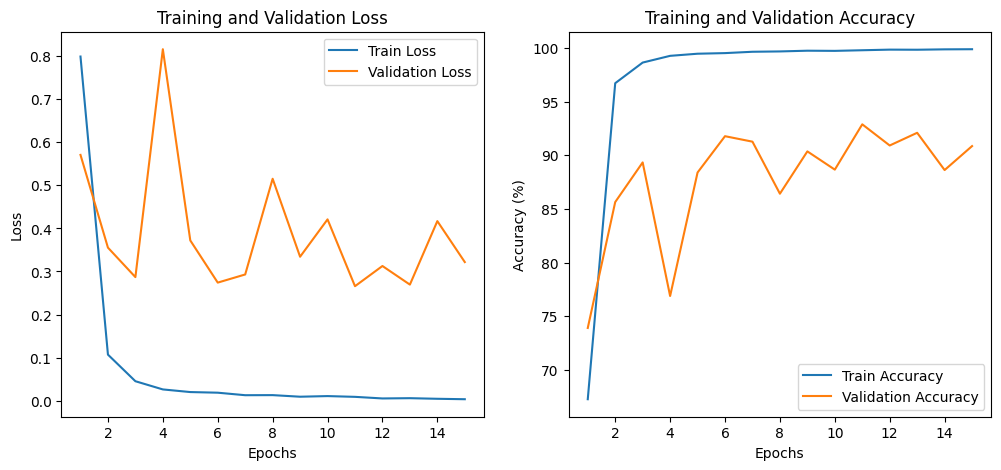

In [ ]:
# 모델 학습
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15)

In [ ]:
# 최종 테스트 평가

print("Final evaluation on the test set...")
test_loss, test_accuracy = evaluate_model(trained_model, test_loader, criterion)
print(f'Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_accuracy:.2f}%')

Final evaluation on the test set...
Final Test Loss: 0.2965, Final Test Accuracy: 91.35%


In [ ]:
# 모델 크기 출력
model_size = get_model_size(model)

size, unit = get_model_size(model)
print(f"Model size: {size:.2f} {unit}")

Model size: 559.43 KB


In [ ]:
# 비제로 가중치 수 계산
nonzero_weights, total_weights = count_nonzero_weights(trained_model)
print(f"Number of non-zero weights: {nonzero_weights}")
print(f"Total number of weights: {total_weights}")
print(f"Percentage of non-zero weights: {100 * nonzero_weights / total_weights:.2f}%")

Number of non-zero weights: 140277
Total number of weights: 140277
Percentage of non-zero weights: 100.00%


In [ ]:
# 모델 평가 함수 (혼동 행렬 포함)
def evaluate_model(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 샘플 수 기반 loss 누적
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    conf_matrix = confusion_matrix(all_labels, all_predictions)
    accuracy = 100 * correct / total

    # 전체 샘플 수로 나누기
    return val_loss / total, accuracy, conf_matrix

In [ ]:
# 평가 및 시각화 예시
test_loss, test_accuracy, test_conf_matrix = evaluate_model(model, test_loader, criterion)
print(f"test Loss: {test_loss:.4f}")
print(f"test Accuracy: {test_accuracy:.2f}%")
print("Confusion Matrix:")
print(test_conf_matrix)


test Loss: 0.2965
test Accuracy: 91.35%
Confusion Matrix:
[[3582    0   18    0    0]
 [   0 3193    0  407    0]
 [   0    0 3598    2    0]
 [   0    0    0 3600    0]
 [   0    0    0 1130 2470]]


In [ ]:
# 혼동 행렬 시각화
def plot_confusion_matrix(conf_matrix, label_encoder, title="Confusion Matrix"):
    categories = label_encoder.classes_
    plt.figure(figsize=(7, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=categories, yticklabels=categories,
                linewidths=0.5, linecolor='gray')

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()
    plt.show()

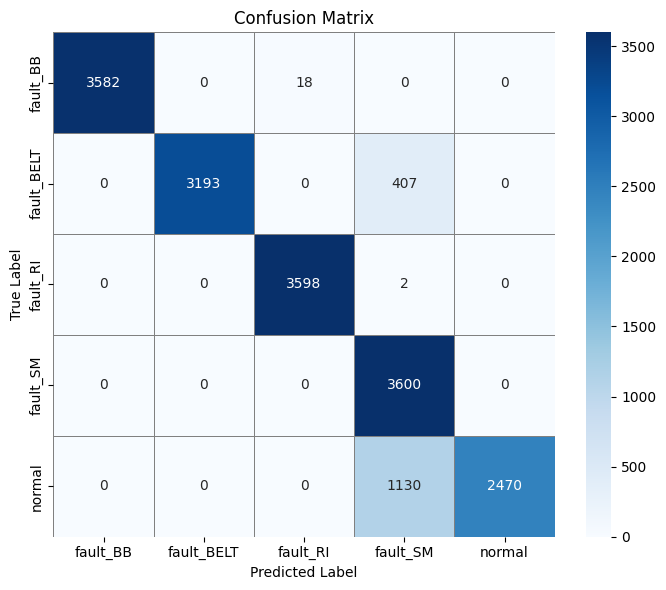

In [ ]:
# 혼동 행렬 시각화
label_encoder = LabelEncoder()
label_encoder.fit(categories)
plot_confusion_matrix(test_conf_matrix, label_encoder)

In [ ]:
from fvcore.nn import FlopCountAnalysis, flop_count_table

# FLOPs 계산 함수
def calculate_flops(model, input_size):
    model.eval()  # 평가 모드로 전환
    dummy_input = torch.randn(*input_size).to(device)  # 가짜 입력 생성
    flops = FlopCountAnalysis(model, dummy_input)
    return flops

# 입력 크기 정의 (배치 크기, 채널, 길이)
input_size = (1, 1, input_length)  # 배치 크기 1, 채널 1, input_length 사용

# FLOPs 계산
flops = calculate_flops(trained_model, input_size)

# 결과 출력
print(f"Total FLOPs: {flops.total() / 1e6:.2f} MFLOPs")  # FLOPs를 MegaFLOPs 단위로 변환
print(flop_count_table(flops))

Total FLOPs: 24.55 MFLOPs
| module                   | #parameters or shape   | #flops    |
|:-------------------------|:-----------------------|:----------|
| model                    | 0.14M                  | 24.551M   |
|  stem                    |  0.272K                |  0.408M   |
|   stem.0                 |   0.24K                |   0.36M   |
|    stem.0.weight         |    (16, 1, 15)         |           |
|   stem.1                 |   32                   |   48K     |
|    stem.1.weight         |    (16,)               |           |
|    stem.1.bias           |    (16,)               |           |
|  block1.block            |  1.824K                |  1.8M     |
|   block1.block.0         |   0.512K               |   0.768M  |
|    block1.block.0.weight |    (32, 16, 1)         |           |
|   block1.block.1         |   64                   |   96K     |
|    block1.block.1.weight |    (32,)               |           |
|    block1.block.1.bias   |    (32,)             

In [ ]:
print("\nCalculating F1 Score...")
calculate_f1_score(trained_model, test_loader, device)


Calculating F1 Score...
F1 Score: 0.9145


In [ ]:
# 파라미터 수 계산 함수
def calculate_total_params(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total Parameters: {total_params:,}")

In [ ]:
print("\nCalculating Total Parameters...")
calculate_total_params(trained_model)


Calculating Total Parameters...
Total Parameters: 140,277


In [ ]:
# 자원 제한 설정 함수
def setup_limited_resources(cpu_only=True, num_threads=2):
    if cpu_only:
        device = torch.device("cpu")
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # CPU 환경일 경우 스레드 수 제한
    if device.type == "cpu":
        torch.set_num_threads(num_threads)
        print(f"CPU 환경: 스레드 수를 {num_threads}개로 제한합니다.")
    else:
        print(f"GPU 환경: {torch.cuda.get_device_name(0)} 사용 중.")

    return device

In [ ]:
# 추론 시간 측정 함수
def measure_inference_time(model, input_data, device, iterations=100):
    model.eval()
    model.to(device)
    input_data = input_data.to(device)

    # 추론 시간 측정
    with torch.no_grad():
        start_time = time.time()
        for _ in range(iterations):
            _ = model(input_data)
        end_time = time.time()

    avg_time = (end_time - start_time) / iterations
    print(f"Average Inference Time: {avg_time * 1000:.2f} ms")
    return avg_time

In [ ]:
# 1. 모델 저장
torch.save(model, "trained_model.pth")
print("Model saved as 'trained_model.pth'")

# 2. CPU 환경 설정
device_cpu = setup_limited_resources(cpu_only=True, num_threads=2)

# 3. 모델 로드
model = torch.load("trained_model.pth", map_location=device_cpu, weights_only=False)
model.to(device_cpu)
model.eval()
print("Model loaded and moved to CPU.")

Model saved as 'trained_model.pth'
CPU 환경: 스레드 수를 2개로 제한합니다.
Model loaded and moved to CPU.


In [ ]:
# 데이터 로더에서 샘플 데이터 가져오기
for input_data, _ in test_loader:
    break  # 첫 번째 배치만 가져옴

# 배치에서 첫 번째 샘플 선택 (배치 크기 1로 설정)
input_data = input_data[0:1].to(device_cpu)

In [ ]:
# 5. 제한된 환경에서 추론 시간 측정
print("\nMeasuring Inference Time on CPU...")
measure_inference_time(model, input_data, device_cpu, iterations=100)


Measuring Inference Time on CPU...
Average Inference Time: 8.02 ms


0.008020527362823486